In [1]:
# Import the necessary libraries
import emcee

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pyazr import azure2
from natsort import natsorted
from brick.azr import AZR as brick

# Define the data labels (in AZURE2 order)
labels = ["Meyer et al. (1976) - 84.3 deg",
          "Meyer et al. (1976) - 114.5 deg",
          "Meyer et al. (1976) - 144.1 deg", 
          "LUNA HPGe (2023)", 
          "LUNA BGO (2023)",
          "Felsenkeller (2023)",
          "ATOMKI (2023)",
          "Kettner et al. (2023) - 0 deg",
          "Notre Dame (2023) - 55 deg",
          "Burtebaev et al. (2008)",
          "Lamb et al. (1957)",
          "Bailey et al. (1950)",
          "Vogl et al. (1963)",
          "Rolfs et al. (1974) - 0 deg",
          "Rolfs et al. (1974) - 90 deg"]

# Define the segment titles
titles = [r'(p,$\gamma$) Integrated', 
          r'(p,$\gamma$) Differential - 0 deg', r'(p,$\gamma$) Differential - 55 deg', r'(p,$\gamma$) Differential - 90 deg', 
          "(p,p) Differential - 84.3 deg", "(p,p) Differential - 114.5 deg", "(p,p) Differential - 144.1 deg"]

In [2]:
# We read the .azr file and set the external capture file to speed up the calculation
azr = azure2('12c_pg.azr')
theta0 = azr.params
ntheta = len(theta0)

# We'll read the data from the output file since it's already in the center-of-mass frame
y = azr.cross
yerr = azr.cross_err
ndata = sum( len(segment) for segment in y )

# Get the lables
brk = brick( "12c_pg.azr" )
params_labels = brk.config.labels
params_labels[-len(labels):] = labels

Calculating Lo-Matrix, Phases, and Penetrabilities...
Calculating Legendre Polynomials...
Calculating Coulomb Amplitudes...
Calculating External Capture Amplitudes...


In [3]:
# Calculated squared residuals
def least_squares( mu, theta ):
    res = 0
    for i in range( len( mu ) ):
        idx = ntheta + i
        res += np.sum( pow( (mu[i] - y[i] * theta[idx]) / ( yerr[i] * theta[idx] ), 2 ) )
    return res

# Function to minimize
def func( theta, proc=0 ):
    mu = azr.calculate( theta[:ntheta], proc=proc )
    ndata = 0
    for i in range( len( mu ) ):
        ndata += len( mu[i] )
    fcn = least_squares( mu, theta ) / ( ndata - len(theta) )
    return fcn

In [4]:
minima, samples = { }, { }

for file in glob( "results/frequentist/samples_*" ):
    data = np.loadtxt( file )
    data = np.array( data )

    m = file.split("_")[-1].split(".")[0]

    samples[m] = []
    minima[m] = []

    for theta in tqdm(data):
        theta = theta[1:]
        chi2 = func( theta )
        if( chi2 < 26 and chi2 > 25.45 ):
            samples[m].append( theta )
            minima[m].append( chi2 )

100%|██████████| 5415/5415 [01:29<00:00, 60.33it/s]


In [5]:
print( len(samples["minuit"]) )

2542


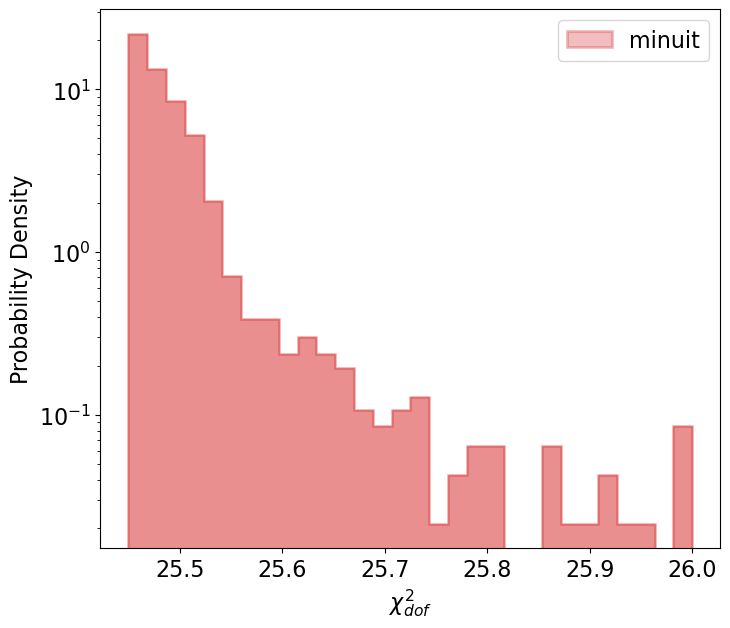

In [9]:
# Plot the chi^2 distribution
plt.figure( figsize=(8,7) )

# Set the font size
plt.rcParams.update({'font.size': 16})

color_map = { "powell": "red", "leastsq": "blue", "nelder": "green", 
              "minuit": "tab:red",   "squares": "orange",     "6": "cyan" }

for m in glob( "results/frequentist/samples_*" ):
    m = m.split("_")[-1].split(".")[0]
    minima[m] = np.array( minima[m] )

    color = color_map[m]

    #if( m == "squares" ): continue
    #if( m == "powell" ): continue
    #if( m == "leastsq" ): continue
    #if( m == "iminuit" ): continue

    plt.hist( minima[m], bins=30, alpha=0.3, range=(25.45,26), histtype='step', color=color, fill=True, density=True )
    plt.hist( minima[m], bins=30, alpha=0.3, range=(25.45,26), lw=2, label=m, histtype='step', color=color, fill=True, density=True )

#plt.hist( minima, bins=100, alpha=0.3, range=(4.45,5), label="Frequentist (1)", color="red", histtype='step', fill=True )
#plt.hist( minima, bins=100, range=(4.45,5), label="Frequentist (1)", color="red", histtype='step', fill=False, lw=2, edgecolor="red" )

plt.yscale( "log" )
plt.xlabel( '$\chi _{dof} ^{2}$' )
plt.ylabel( "Probability Density" )

plt.legend()

#plt.xlim( 4.45, 5 )

plt.savefig( "results/extra/minima.pdf" )
plt.show()

In [7]:
from scipy import stats

priors = [
    stats.norm(1.63,0.12),

    stats.uniform(2.30, 0.10), stats.uniform(0, 1e6), stats.uniform(-10, 20),
    stats.uniform(-1e8,2e8),

    stats.uniform(3.45, 0.10), stats.uniform(0, 1e6), stats.uniform(-10, 20), stats.uniform(-10, 20),
    stats.uniform(-1e8,2e8), stats.uniform(-1e8,2e8),

    stats.uniform(3.50, 0.10), stats.uniform(0, 1e6),
    
    stats.lognorm(0.05),
    stats.lognorm(0.05),
    stats.lognorm(0.05),
    stats.lognorm(0.069),
    stats.lognorm(0.079),
    stats.lognorm(0.10),
    stats.lognorm(0.06),
    stats.lognorm(0.10),
    stats.lognorm(0.10),
    stats.lognorm(0.10),
    stats.uniform(0, 100),
    stats.uniform(0, 100),
    stats.uniform(0, 100),
    stats.uniform(0, 100),
    stats.uniform(0, 100)
]

# Get 1000 samples from the prior
params = np.array( [ [ dist.rvs() for dist in priors ] for i in range(10000) ] )

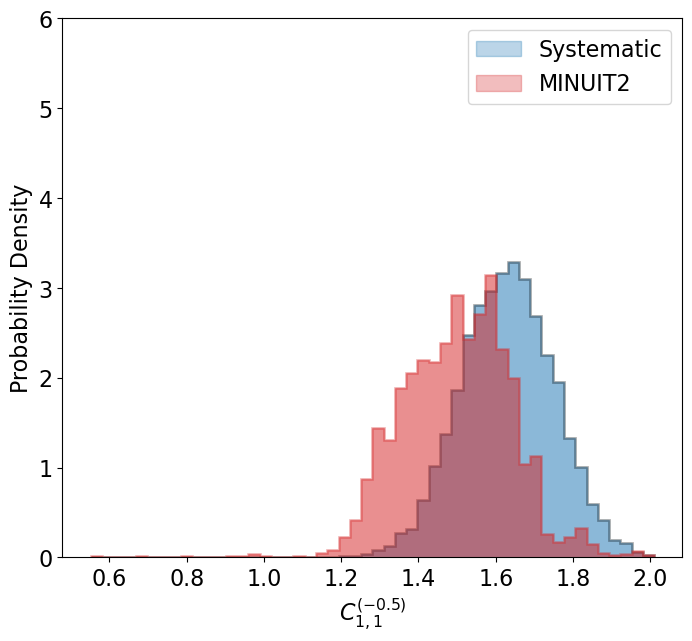

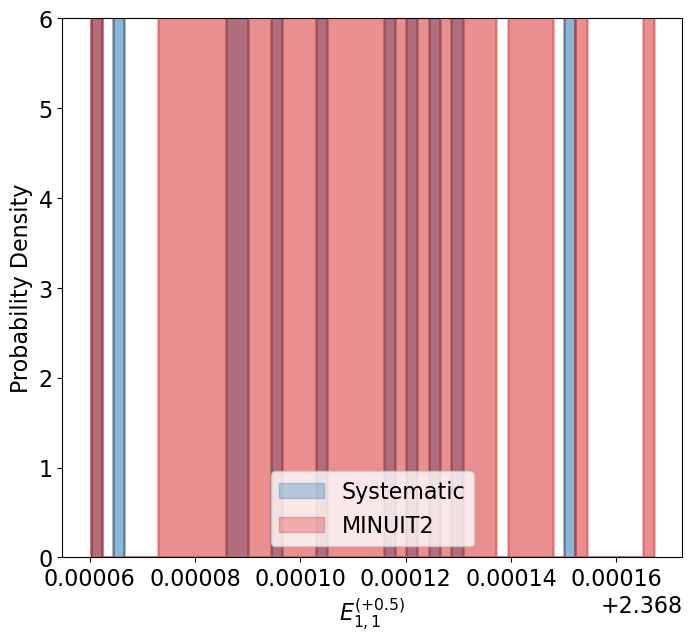

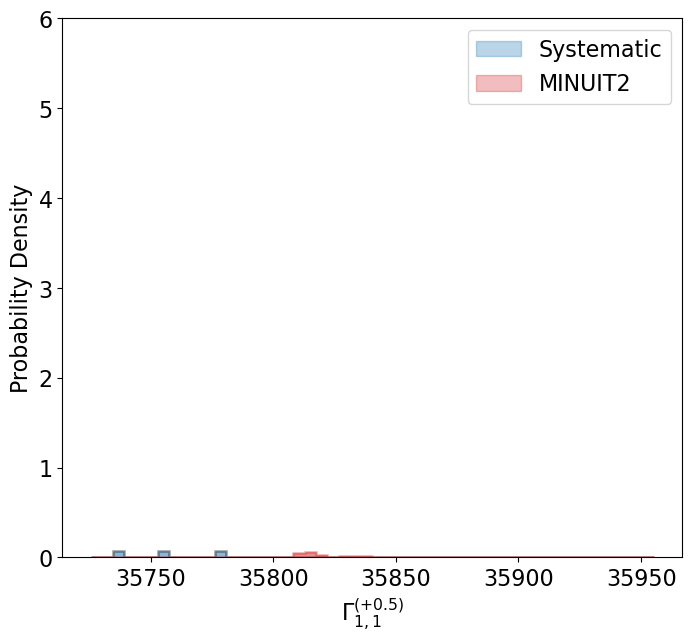

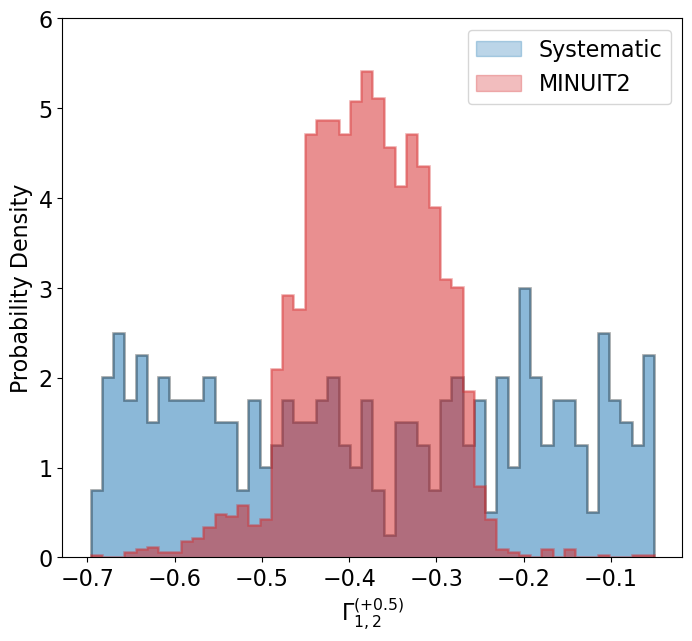

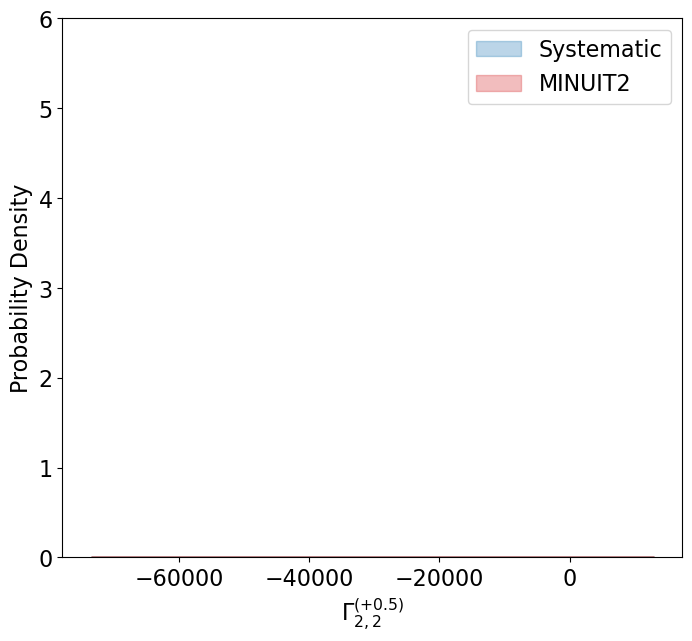

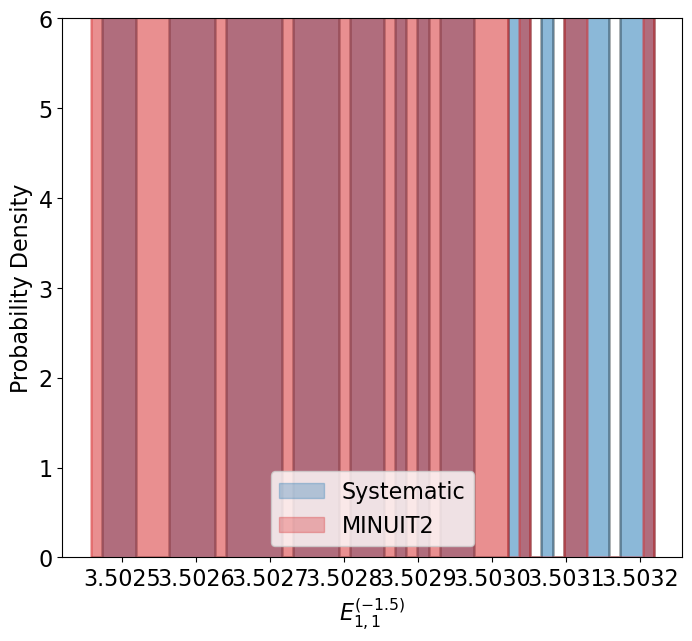

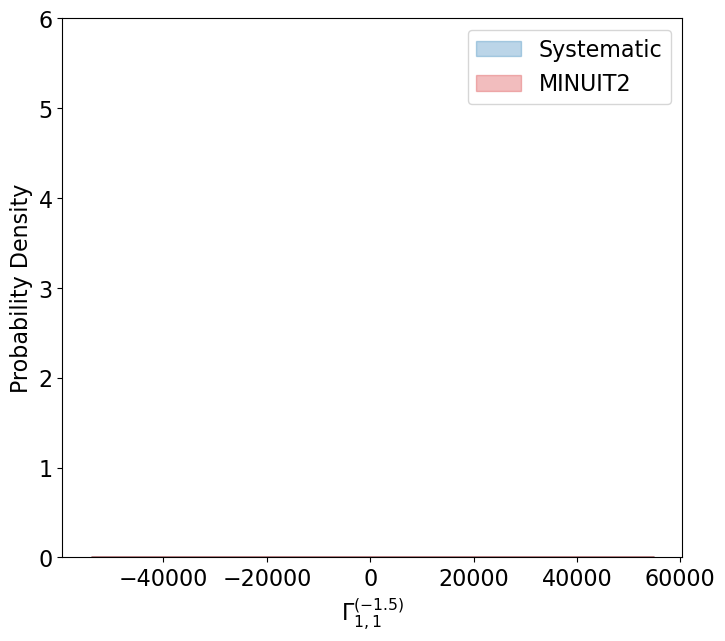

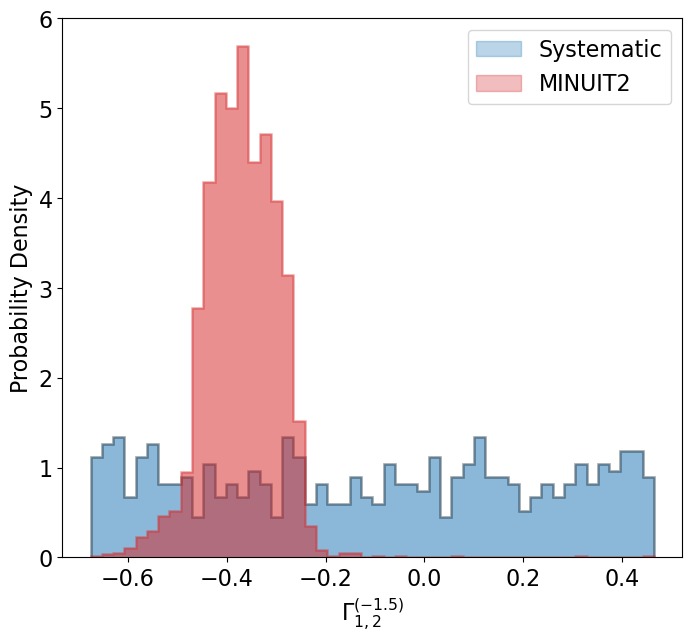

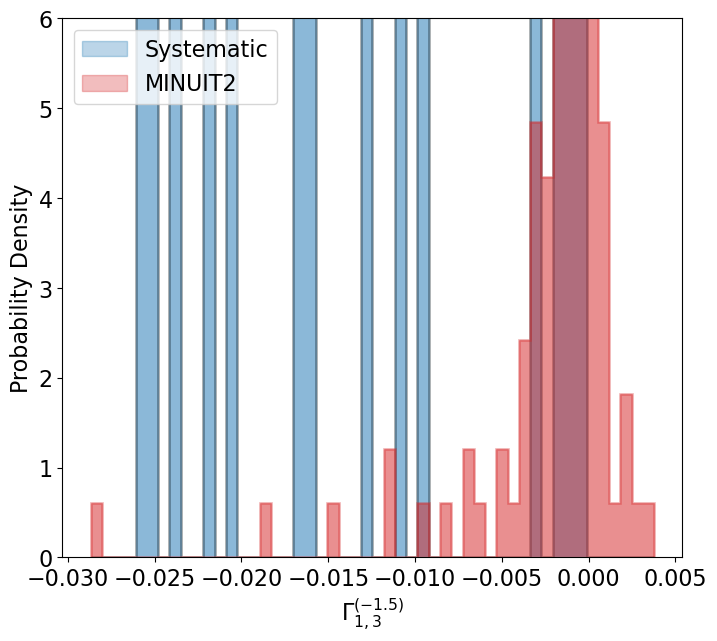

/Users/kuba/miniforge3/envs/analysis/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


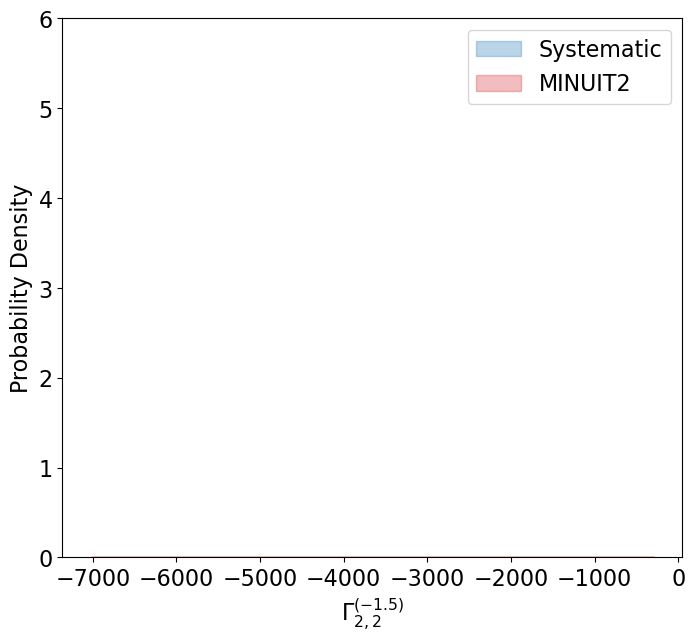

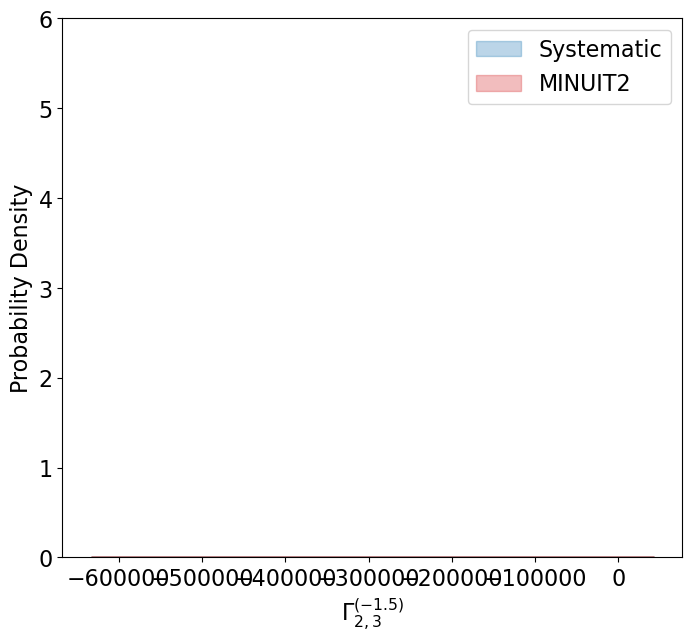

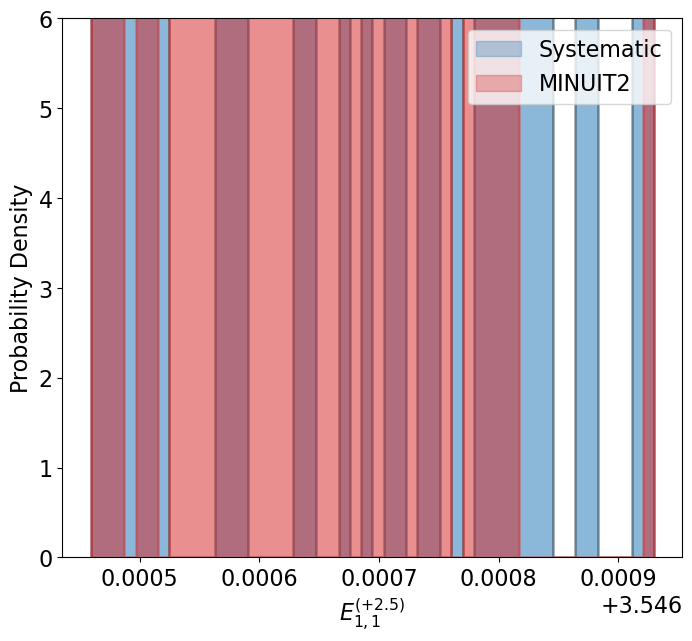

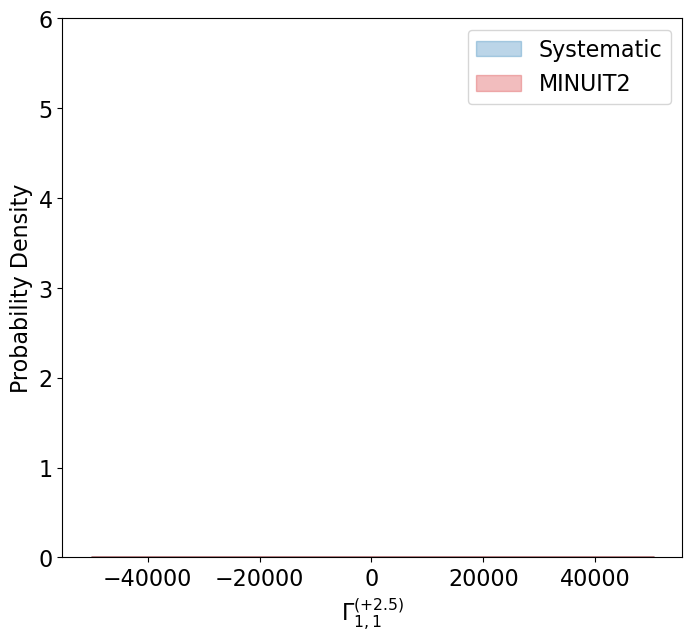

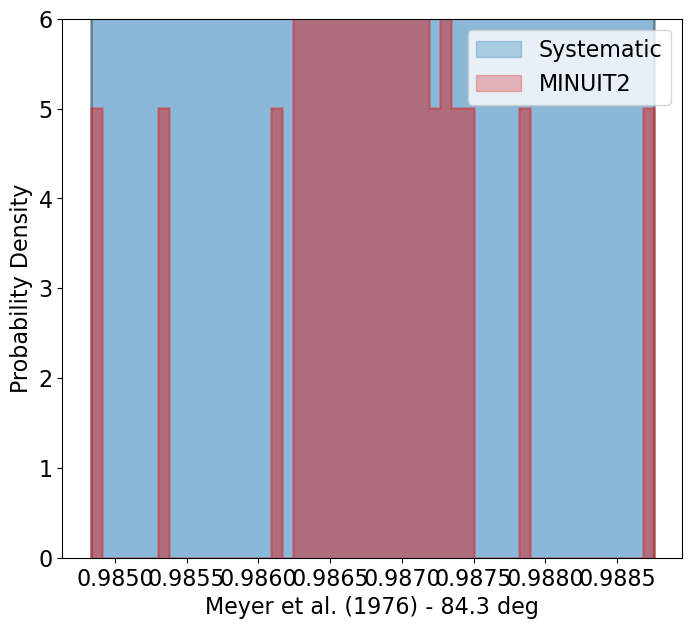

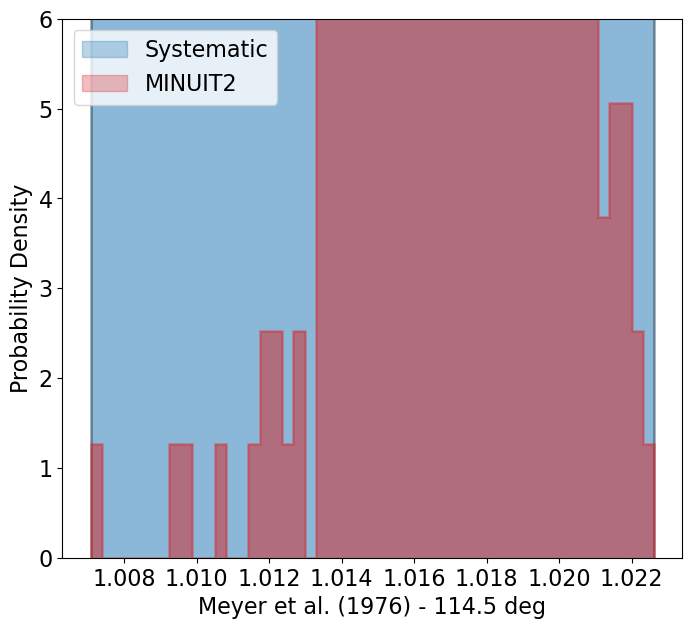

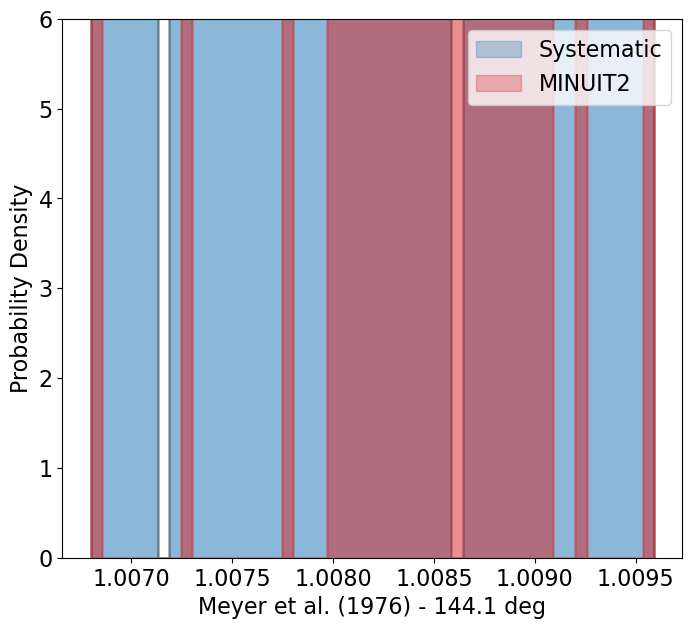

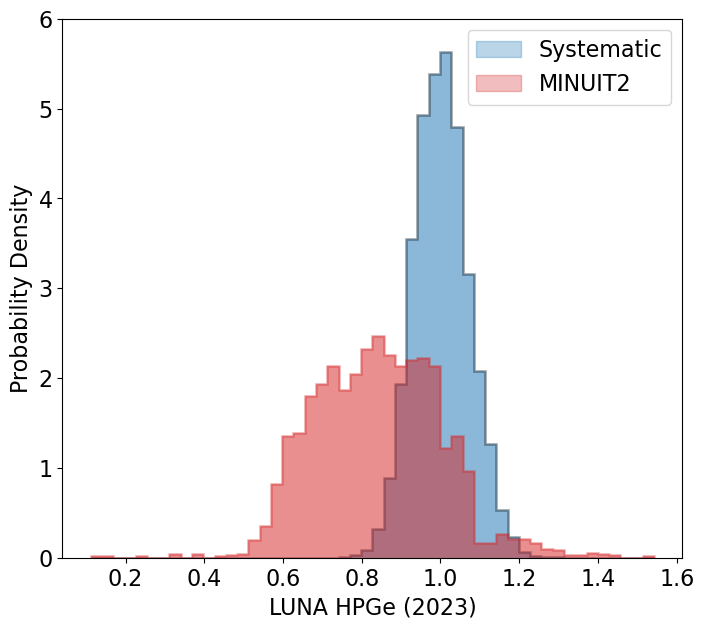

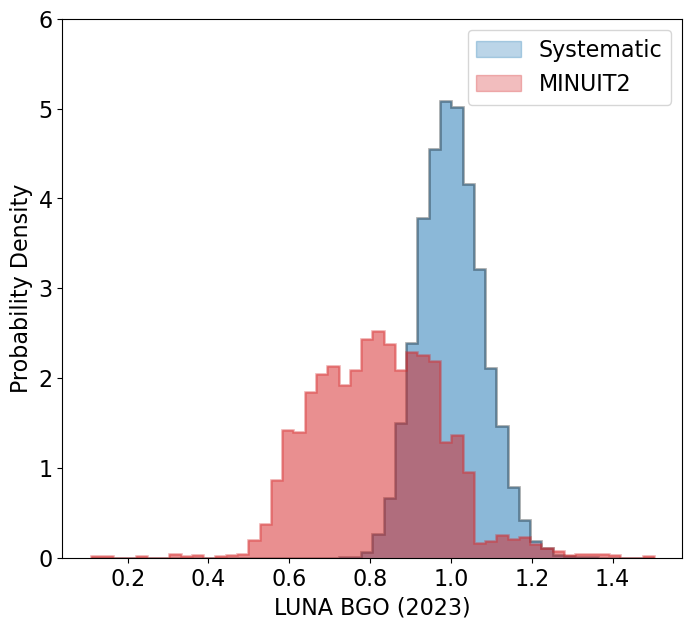

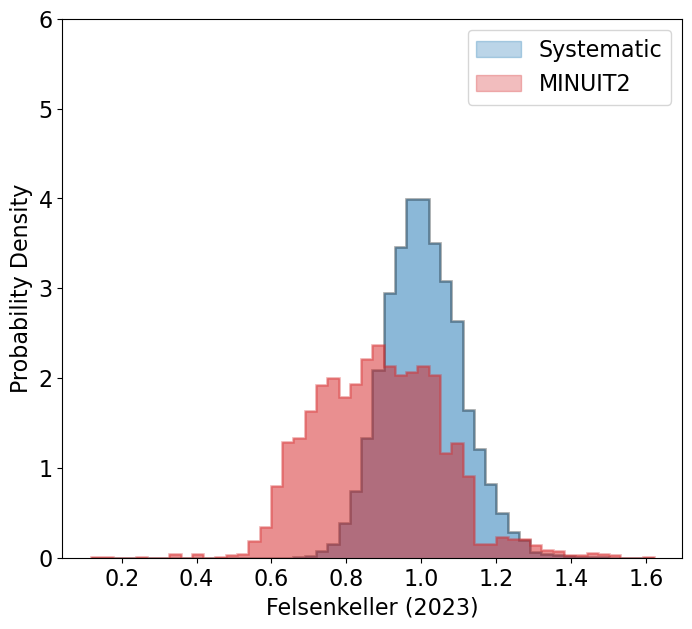

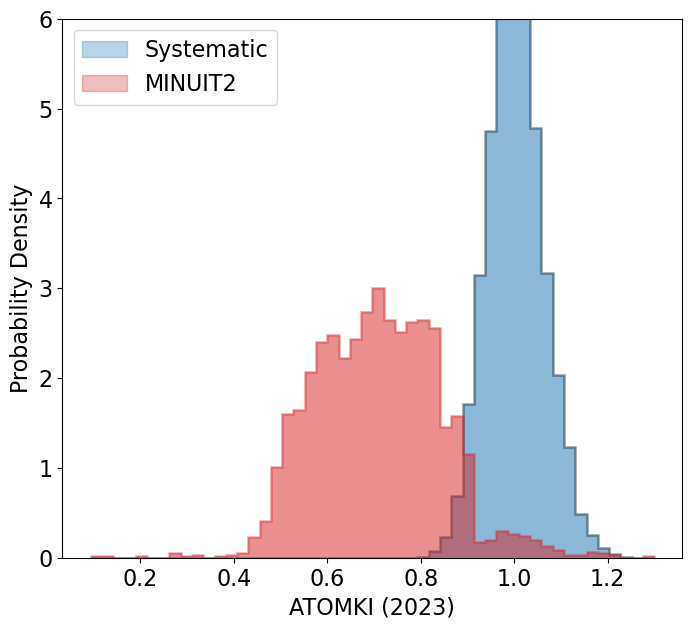

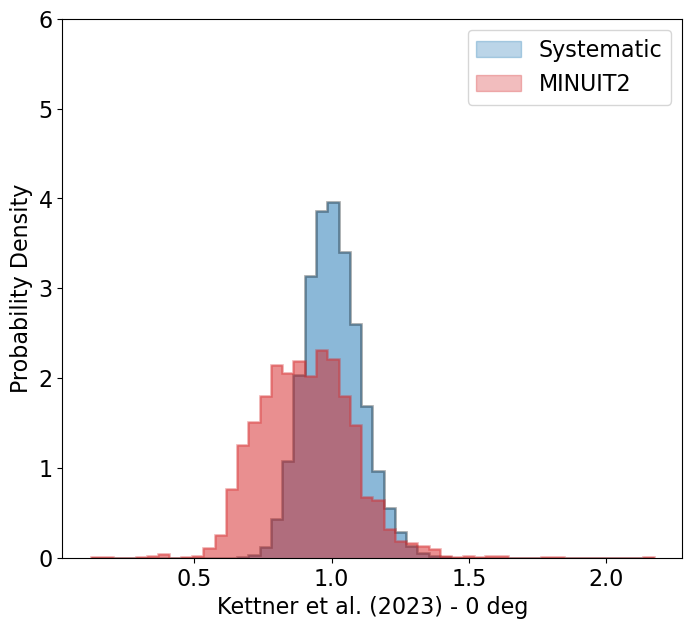

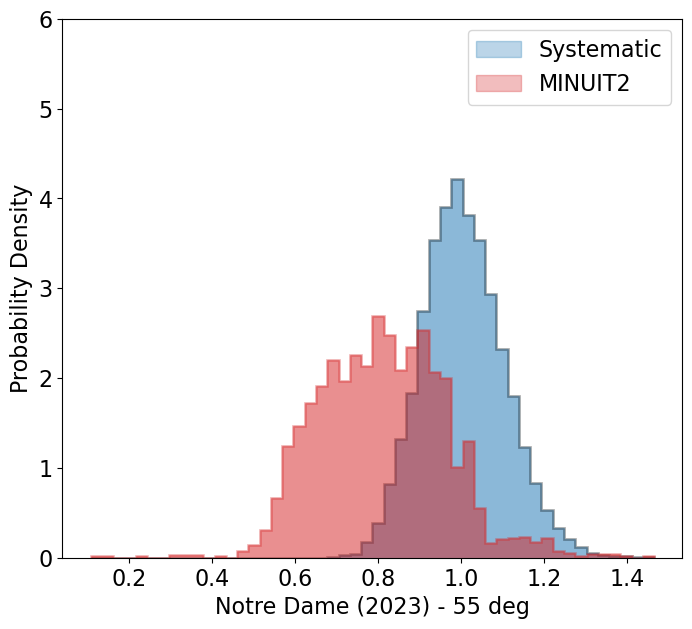

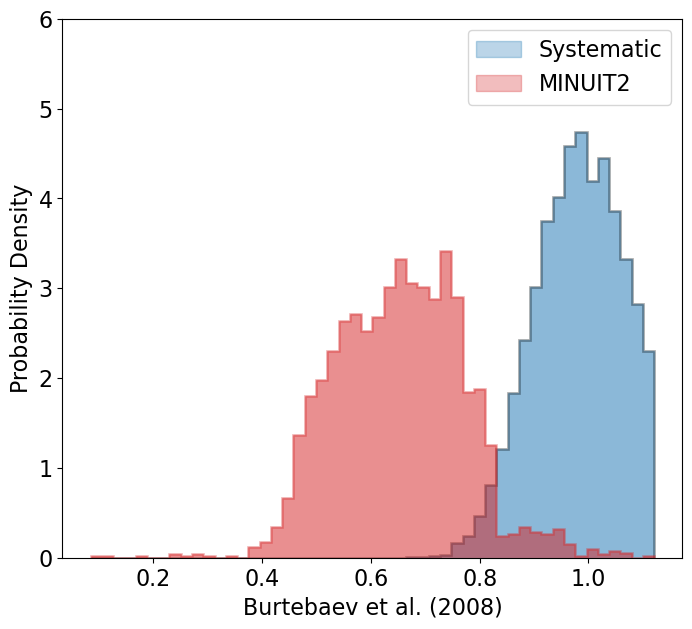

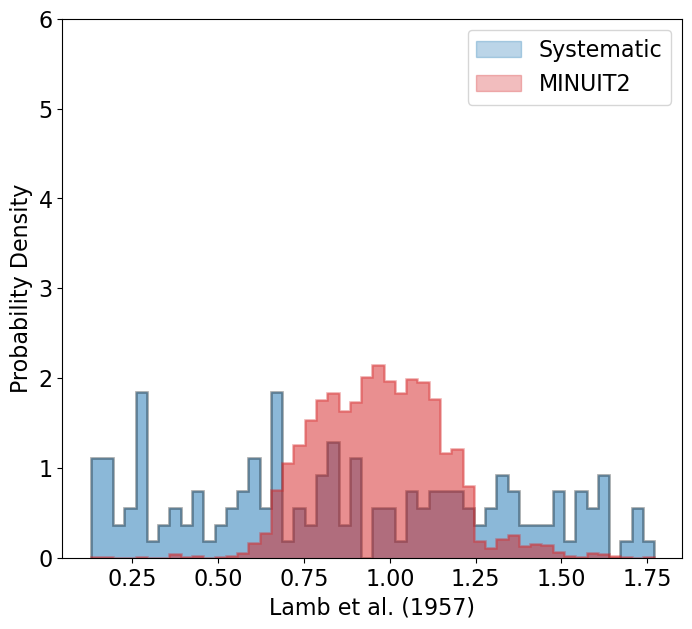

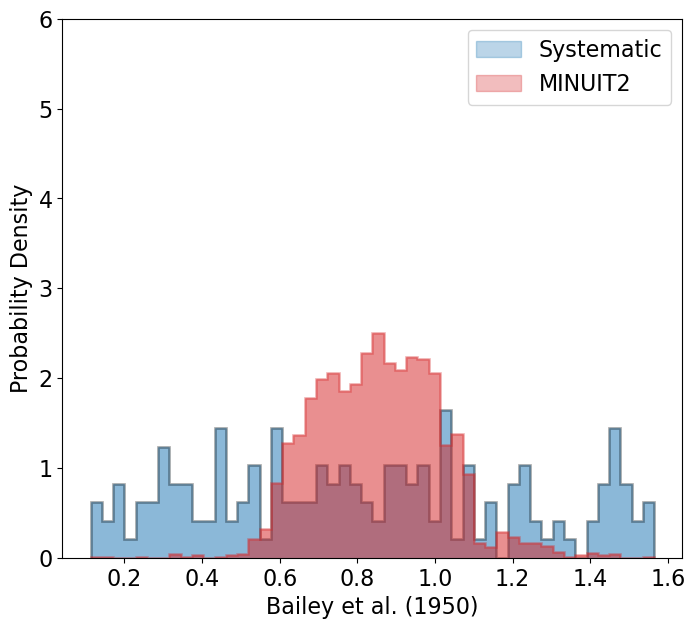

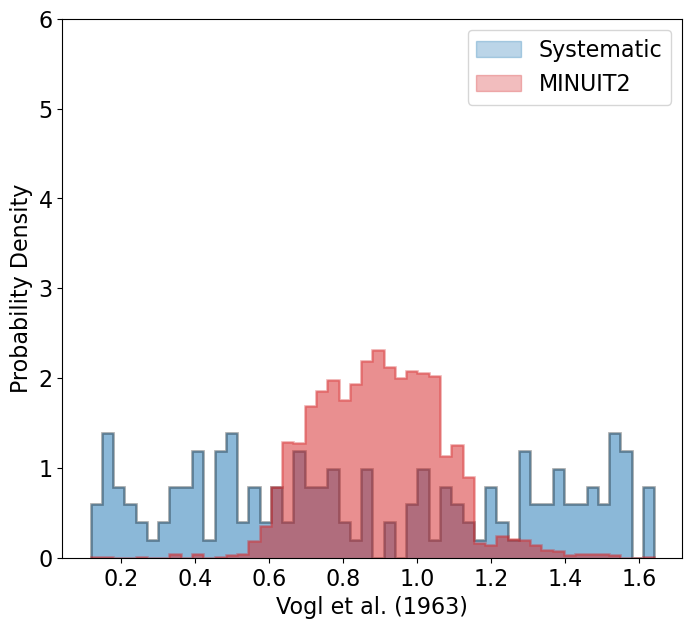

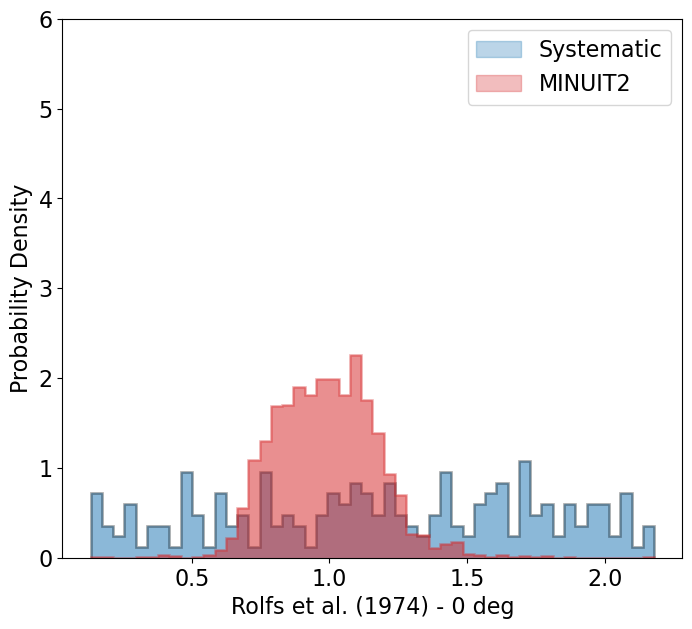

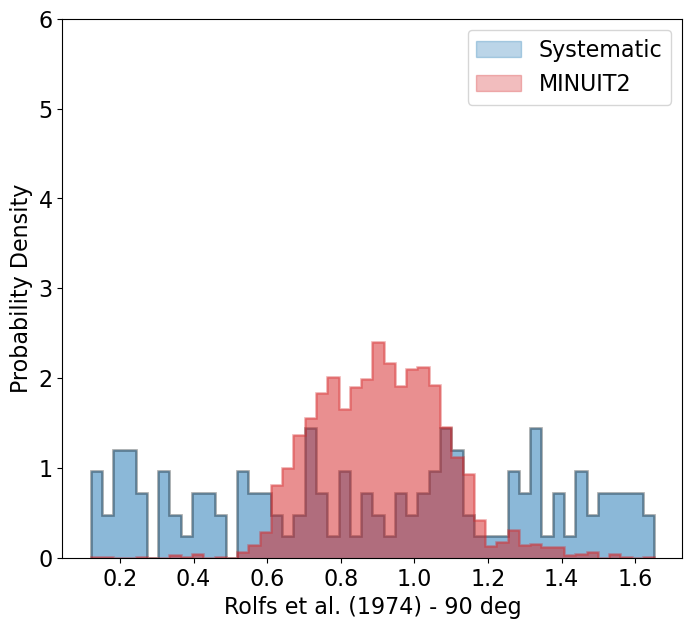

In [8]:
# Plot the histograms of the parameters
for i in range( len( samples["minuit"][0] ) ):
    fig, ax = plt.subplots( 1, 1, figsize=( 8, 7 ) )

    samples["minuit"] = np.array( samples["minuit"] )

    range_ = (samples["minuit"][:,i].min(), 
              samples["minuit"][:,i].max())
    
    plt.hist( params[:,i], bins=50, alpha=0.3, color="tab:blue", range=range_, label="Systematic", histtype='step', fill=True, density=True )
    plt.hist( params[:,i], bins=50, alpha=0.3, color="tab:blue", range=range_, histtype='step', edgecolor='black', linewidth=2, fill=True, density=True )

    #plt.yscale( "log" )
    
    # Set lower limit on yaxis
    plt.ylim( 1e-1, 4e1 )

    for file in glob( "results/frequentist/samples_*" ):

        m = file.split("_")[-1].split(".")[0]

        samples[m] = np.array( samples[m] )

        if( samples[m].size == 0 ): continue
        if( m in ["squares", "powell", "leastsq"] ): continue

        label = "MINUIT2" if m == "minuit" else "Levenberg-Marquardt"

        plt.hist( samples[m][:,i], bins=50, alpha=0.3, color=color_map[m], range=range_, label=label, histtype='step', fill=True, density=True )
        plt.hist( samples[m][:,i], bins=50, alpha=0.3, color=color_map[m], range=range_, histtype='step', edgecolor=color_map[m], fill=True, linewidth=2, density=True )


    ax.set_xlabel( params_labels[i] )
    ax.set_ylabel( "Probability Density" )
    #ax.set_yscale( "log" )
    ax.legend( )

    # Put upper y limit at 6
    plt.ylim( 0, 6 )

    plt.savefig( "results/extra/parameter_{}.pdf".format( i ) )
    plt.show( )

In [9]:
# Make a corner plot
import corner

fig = corner.corner( samples["powell"], labels=params_labels, show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12}, range=[0.99]*len(params_labels) )

ModuleNotFoundError: No module named 'corner'